# 2 Data Preparation

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
(361, 8, 8)
(216, 8, 8) (145, 8, 8)
[[ 0.  0.  0.  3.  9. 16. 16.  2.]
 [ 0.  0.  4. 16. 13. 11. 16.  1.]
 [ 0.  0.  3.  5.  0.  6. 13.  0.]
 [ 0.  0.  0.  2.  7. 14.  9.  0.]
 [ 0.  0.  4. 16. 16. 15.  3.  0.]
 [ 0.  0.  9.  8. 11. 12.  0.  0.]
 [ 0.  0.  0.  0. 12.  4.  0.  0.]
 [ 0.  0.  0.  2. 15.  1.  0.  0.]]
[ 0.  0.  0.  3.  9. 16. 16.  2.]


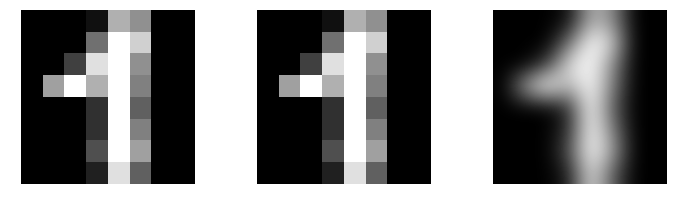

In [22]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn import model_selection


#import data
digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_name = digits["target_names"]


#filter data
condition = np.logical_or(target == 1, target == 7)

labels = np.extract(condition,target) #target: 1 or 7
features = images[np.where(condition)] #images showing 1 or 7

print(features.shape)



#training and test set
X_all = features
y_all = labels
X_train, X_test, y_train , y_test = model_selection.train_test_split(
                                    X_all,
                                    y_all,
                                    test_size = 0.4,
                                    random_state = 0)

print(X_train.shape, X_test.shape)
print(X_train[0,:,:])

print(X_train[0,0,:])

img = features[9,:,:]
assert 2 == len( img . shape )

fig = plt.figure(figsize = (10,3))
plt.gray()
plt.subplot('131'); plt.axis('off')
plt.imshow(img, interpolation = "nearest")
plt.subplot('132'); plt.axis('off')
plt.imshow(img, interpolation = "nearest")
plt.subplot('133'); plt.axis('off')
plt.imshow(img, interpolation = "bicubic")
fig.tight_layout(); plt.show()

## 2.1 Dimension Reduction

The feature dimensions I choose are:

1) Ratio white/black over number of non black cells

2) How many of the upper row pixels are non black?

In [23]:
def reduce_dim(x):
    
    feature_one = np.divide(np.sum(x,axis=(1,2)),np.count_nonzero(x,axis=(1,2)))
    feature_two = np.add(np.count_nonzero(x[:,0,:],axis=1),np.count_nonzero(x[:,4,:],axis=1))

    
    return np.array([feature_one, feature_two]).T

#test example
reduce_x = reduce_dim(X_train)          
print(reduce_x.shape)

(216, 2)


## 2.2 Scatterplot

(182, 8, 8) (179, 8, 8)


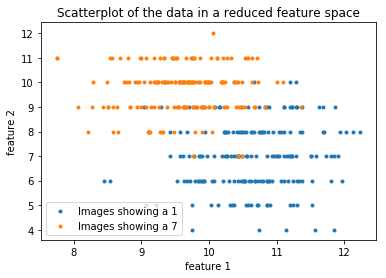

In [24]:
X_1 = X_all[np.where(y_all ==1)]
X_7 = X_all[np.where(y_all ==7)]

print(X_1.shape, X_7.shape)

#position in featurespace
x,y = reduce_dim(X_1).T
a,b = reduce_dim(X_7).T

plt.scatter(x,y, label='Images showing a 1', marker='.')
plt.scatter(a,b, label='Images showing a 7', marker='.')
plt.title('Scatterplot of the data in a reduced feature space')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()


As can be seen in the scatterplot above, the areas defined by the different labels overlap in the feature space, but a tendency is visible.

# 3 Nearest Mean
## 3.1 Implementation of the nearest mean classifier

In [6]:
def nearest_mean(training_features, training_labels, test_features):
    
    #split training data according to label
    im_1 = training_features[np.where(training_labels==1)]
    im_7 = training_features[np.where(training_labels==7)]
    
    #calc mean position of training data in feature space
    mean_1 = np.mean(im_1, axis=0)
    mean_7 = np.mean(im_7, axis=0)
    print(mean_1, mean_7)
    
    #squared distance of the test_features to means of training data
    dist_1 = np.sum(np.square(np.subtract(mean_1,test_features)), axis=1)
    dist_7 = np.sum(np.square(np.subtract(mean_7,test_features)), axis=1)
    
    #prediction made on squared distance
    predicted_labels = np.ones(len(test_features))
    predicted_labels[np.where(dist_1 > dist_7)] = 7
    
    return predicted_labels

predicted_labels = nearest_mean(reduce_dim(X_train), y_train, reduce_dim(X_test))

print(predicted_labels[:5])

[10.60822946  6.93495935] [9.59778221 9.64516129]
[7. 7. 7. 1. 7.]


## 3.2 Visualize the decision regions

This is a bit more difficult in our case, because we chose one of the features to be an integer within $f_2\in[0,16]$
We choose our grid to have the resolution 200x20

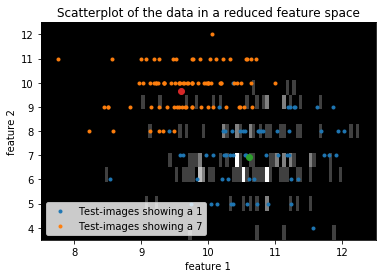

In [60]:
#the test data in feature space
X_test_1 = X_test[np.where(y_test ==1)]
X_test_7 = X_test[np.where(y_test ==7)]
x_pos_t1, y_pos_t1 = reduce_dim(X_test_1).T
x_pos_t7, y_pos_t7 = reduce_dim(X_test_7).T
plt.scatter(x_pos_t1, y_pos_t1, label='Test-images showing a 1', marker='.')
plt.scatter(x_pos_t7, y_pos_t7, label='Test-images showing a 7', marker='.')

#the mean in feature_space
training_features = reduce_dim(X_train)
training_labels = y_train
    #split training data according to label
im_1 = training_features[np.where(training_labels==1)]
im_7 = training_features[np.where(training_labels==7)]
    #calc mean position of training data in feature space
mean_1 = np.mean(im_1, axis=0)
mean_7 = np.mean(im_7, axis=0)
x_pos_m1, y_pos_m1 = mean_1
x_pos_m7, y_pos_m7 = mean_7
plt.scatter(x_pos_m1, y_pos_m1, marker='o')
plt.scatter(x_pos_m7, y_pos_m7, marker='o')

#the decision regions
    #grid
range_f = [[7.5,12.5],[3.5,12.5]]
bins_f = [100,15]
F_1 = np.linspace(7.5,12.5,100)
F_2 = np.linspace(3.5,12.5,15)
f1,f2 = np.meshgrid(F_1, F_2)
    #position training data
X_train_1 = X_train[np.where(y_train ==1)]
X_train_7 = X_train[np.where(y_train ==7)]
x_pos_tr1, y_pos_tr1 = reduce_dim(X_train_1).T
x_pos_tr7, y_pos_tr7 = reduce_dim(X_train_7).T

xedge, number_of_1_percell, yedge = np.histogram2d(x_pos_tr1, y_pos_tr1, bins=bins_f, range=range_f)
number_of_7_percell = np.histogram2d(x_pos_tr7, y_pos_tr7, bins=bins_f, range=range_f)[1]
number_per_cell = np.subtract(number_of_1_percell, number_of_7_percell)

plt.hist2d(x_pos_tr7, y_pos_tr7, bins=bins_f, range=range_f)
plt.hist2d(x_pos_tr1,y_pos_tr1, bins=bins_f, range=range_f)
#plt.pcolormesh(f1,f2,number_per_cell)

#pcolor and pcolormesh do not accept values. why??


plt.title('Scatterplot of the data in a reduced feature space')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

# 4 QDA
## 4.1 Implement QDA Training

In [94]:
def covariance(mean, x_vec):
    dist = np.subtract(x_vec,np.ones(x_vec.shape)*mean)
    cov = np.divide(np.matmul(dist.T,dist), len(x_vec))
    return cov

def fit_qda(training_features, training_label_bin):
    
    #label=0 -> digit=1
    #label=1 -> digit=7
        
    #split training data according to label
    im_1 = training_features[np.where(training_label_bin==1)]
    im_7 = training_features[np.where(training_label_bin==7)]
    #calc mean position of training data in feature space
    mean_1 = np.mean(im_1, axis=0)
    mean_7 = np.mean(im_7, axis=0)
    
    mu = np.array([mean_1, mean_7])
    
    #calc cov according to script
    cov_1 = covariance(mean_1,im_1)
    cov_7 = covariance(mean_7,im_7)
    covmat = np.array([cov_1,cov_7])
    
    #
    p_1 = len(im_1)/(len(im_1)+len(im_7))
    p_7 = 1 - p_1
    p = np.array([p_1,p_7])
    
    return mu, covmat, p

a = fit_qda(reduce_dim(X_train), y_train)
print(a)

(array([[10.60822946,  6.93495935],
       [ 9.59778221,  9.64516129]]), array([[[ 0.50245161,  0.04286423],
        [ 0.04286423,  1.88194858]],

       [[ 0.45101729, -0.10089443],
        [-0.10089443,  0.960111  ]]]), array([0.56944444, 0.43055556]))
